# Cross entropy and softmax


In [1]:
import random
from datetime import datetime

import torch
import numpy as np
import fastbook
from torch import tensor

import mnist
from monitoring import graph_updater
from math_funcs import get_accuracy, Sigmoid, ReLU, CrossEntropy, L2
from network import Network

fastbook.setup_book()     

training_set, testing_set, validation_set = mnist.datasets(0.8)

48000 10000 12000


In [19]:
def validate(network, dataset):
    costs, accuracy = [], []
    for xs, expected in iter(dataset):
        a = network.step(xs)
        accuracy.append(get_accuracy(expected, a))
        costs.append(network.cost(expected, a))

    return torch.cat(costs).mean(), torch.stack(accuracy).mean()


In [5]:
def run_batch(network, lr, batch):
    xs, expected = batch
    activations = network.forward(xs)
    output = activations[-1]
    grad = network.gradient(activations, expected)
    network.update(grad, lr)
    return get_accuracy(expected, output), network.cost(expected, output)


def run_epoch(network, dataset, lr):
    accuracy = []
    costs = []
    
    for batch in iter(dataset):
        a, c = run_batch(network, lr, batch)
        accuracy.append(a)
        costs.append(c)

    return tensor(accuracy).float().mean(), torch.stack(costs).mean()


def train(network, dataset, epochs, lr, show_progress=True, test_set=None):
    if show_progress:
        add_datapoint = graph_updater()
    
    for epoch in range(epochs):
        start = datetime.now()
        
        avg_accuracy, avg_cost = run_epoch(network, dataset, lr)
        
        if show_progress and (not epoch % 1):
            print(f'epoch {epoch}: accuracy={round(avg_accuracy.item(), 3)}, cost={round(avg_cost.item(), 3)}, time: {datetime.now() - start}')
            if test_set is not None:
                test_cost, test_accuracy = validate(network, test_set)
                print(f'test accuracy: {round(test_accuracy.item(), 3)}, test cost: {round(test_cost.item(), 3)}')
                add_datapoint(test_accuracy)
            else: 
                add_datapoint(avg_accuracy)
    
    return avg_accuracy, avg_cost

In [6]:
n = Network((28*28, 100, 10))

In [7]:
n_items = 1000
data = mnist.sample(n_items, 10)

In [8]:
#data = mnist.sample(len(training_set.dataset), 64)
data = training_set
n_items = len(training_set.dataset)

network_size = (28*28, 100, 10)
epochs = 10

(tensor(0.9651), tensor(0.0320))

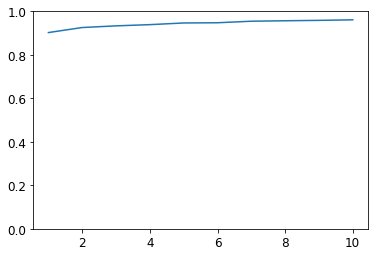

In [25]:
n = Network(network_size)
train(n, data, epochs=epochs, lr=1, test_set=testing_set)

# Cross Entropy loss

Cross entropy was [specially crafted](http://neuralnetworksanddeeplearning.com/chap3.html#what_does_the_cross-entropy_mean_where_does_it_come_from) to handle the slowdown caused by sigmoid derivatives when using a L2 cost function, and it shows. For the following toy networks, just changing the cost function to Cross-Entropy from L2 give a 10 times learning speed boost. It also seems to converge right out of the box, with an almost 90% accuracy after the first epoch. Not bad!

(tensor(0.9575), tensor(46.3093))

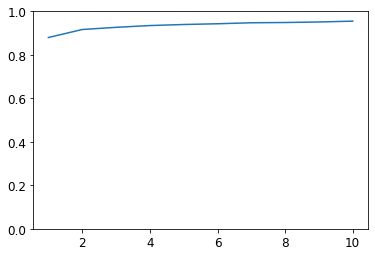

In [9]:
n = Network(network_size, cost_func=CrossEntropy())
train(n, data, epochs=epochs, lr=0.1, test_set=testing_set)

(tensor(0.9689), tensor(45.6767))

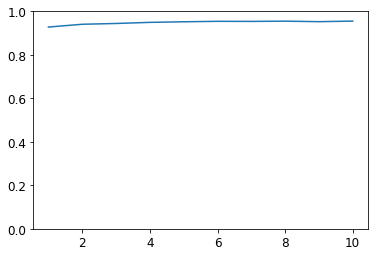

In [10]:
n = Network(
    network_size,
    cost_func=CrossEntropy(),
    regularizator=L2,
    regularization_term=1/n_items
)
train(n, data, epochs=epochs, lr=0.5, test_set=testing_set)

# ReLU
I've read in many places that ReLU is the way to go when choosing activation functions, but I'm not impressed. I wonder what I did wrong... It certainly seems very sensitive to the learning rate.
Using ReLU with a L2 cost function does not work at all. Interesting. This seems like something worth diving deeper into. Fiddling with the learning rate didn't give any bigger gains. 

(tensor(0.1121), tensor(0.4596))

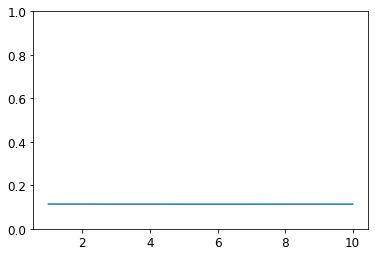

In [13]:
n = Network(network_size, nonlinearity=ReLU())
train(n, data, epochs=epochs, lr=0.002, test_set=testing_set)

(tensor(0.8835), tensor(51.7413))

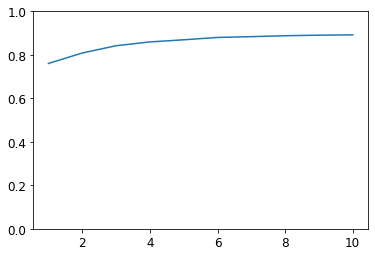

In [16]:
n = Network(
    network_size,
    nonlinearity=ReLU(),
    cost_func=CrossEntropy()
)
train(n, data, epochs=epochs, lr=0.001, test_set=testing_set)

(tensor(0.8834), tensor(51.8189))

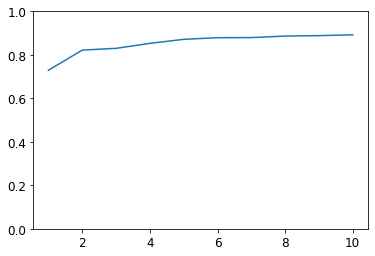

In [17]:
n = Network(
    network_size,
    nonlinearity=ReLU(),
    cost_func=CrossEntropy(),
    regularizator=L2,
    regularization_term=5/n_items
)
train(n, data, epochs=epochs, lr=0.001, test_set=testing_set)